1. Explain the overall purpose of the package.
2. Explain the use of the “Simple random data” and “Permutations” functions.
3. Explain the use and purpose of at least five “Distributions” functions.
4. Explain the use of seeds in generating pseudorandom numbers.

# The numpy.random Package

## Introduction 
### True random number generation

True random number generation is not a simple matter. It is difficult to find phenomena that are unpredictable to the extent that they can provide a long-lasting stream of data from which truly random numbers can be derived. Many applications require cryptographically secure random number generation and there is much research into sources of entropy as diverse as spontaneous chaotic oscillations in semiconductor superlattices [11], atmospheric noise [12], and synthesised DNA strands composed of random nucleotides [13] for the purposes of random number generation. Computer programmes are by nature deterministic making it difficult to generate truly unpredictable random numbers without some external source of entropy. True random number generators attempting to use, for example, the electromagnetic noise arising from current flow across a transistor, must process the signal to remove bias and make uniform, in a manner that controls for many diverse effects such as, for example, temperature and voltage fluctuations, if the numbers generated are to be relied upon as truly random. Failing to do so could introduce inadvertent predictability or provide a route for bad actors to influence the random bit stream [14].

### Pseudorandom number generation and Seeding
For many, or even most, applications, a pseudorandom number generator (PRNG) with the appropriate properties will suffice. A PRNG, also known as a *deterministic* random *bit generator* [15], is an algorithm that, given some initial value, known as a seed, manipulates that seed in some way, then iteratively manipulates the result of that manipulation, and so on, to produce a stream of random bits from which samples can be drawn. Melissa O' Neill, creator of the PCG family of PRNG algorithms, one of which, PCG64, is the default `numpy.random` PRNG, uses the analogy of an enormous book of numbers from which the random numbers are drawn. While all of the numbers in the book are accessible to anyone, the chances of finding the particular page on which a particular sequence of numbers commences are infinitesimal. However, if the page, line, and character number at which to begin was provided, reproducing a sequence of numbers would be easy. Pseudorandom number generators are akin to this book in the sense that they are deterministically produced using a single value as a starting point. The PRNG analogue to the location of the beginning of the random number sequence in the book of numbers is the seed.

## Overview
The purpose of the `numpy.random` package is to provide an interface to a number of PRNGs and the sub-package of the numpy numerical computing Python package that deals with random (really pseudo-random [1]) number generation and random processes such as shuffling, and selecting random items from, sequences. Two classes `numpy.random.BitGenerator` and `numpy.random.Generator` are used together to generate pseudo random numbers. `Generator` can be instantiated in two ways;

1. by calling the constructor with the name of the desired BitGenerator algorithm, or;
1. by calling `numpy.random.default_rng()`, a convenience function which will return a `Generator` object instantiated with the default `BitGenerator`, currently PCG64 [1]  

The second method is the one recommended by the numpy documentation [1].

`numpy.random.BitGenerator` is the base class for all of the bit generators provided by the numpy package. It is an abstract class and so cannot be instantiated. Several BitGenerators are provided by numpy. Of particular interest are `PCG64`, the default `numpy.random` BitGenerator, and `MT19937`, also known as the *Mersenne Twister*[1], the Python language's standard BitGenerator[1]. The `BitGenerator` base class provides the attribute `seed` which is used to initialise whichever BitGenerator is instantiated so that the sequence of numbers it produces are deterministic and therefore reproduceable[8]. If no seed is passed one is generated from system entropy[9]. Whether a seed is passed or not, the `numpy.random.SeedSequence` class is used to generate the `BitGenerator`'s initial state [9]. 

In [50]:
# Imports
import numpy as np
# Used to initialise current default BitGenerator
from numpy.random import default_rng
# Used to initialise any available BitGenerator
from numpy.random import Generator
# Two of numpy's BitGenerators
from numpy.random import PCG64, MT19937
# For plotting distributions, etc
import matplotlib.pyplot as plt

from tabulate import tabulate

The recommended method for intialising a random number generator is with the `numpy.random.default_rng()` function [1]. This returns a `Generator` object. The `Generator`'s bit generator can be accessed via its `bit_generator` attribute. It can be seen here that calling `default_rng` has returned a `Generator` intitialised with the `PCG64` bit generator.

In [2]:
# Initialise Generator with default 
# BitGenerator (PCG64) with seed 0
rng = default_rng(99)
print(f"Type returned by default_rng():\t\t{type(rng)}")
print(f"BitGenerator returned by default_rng():\t{type(rng.bit_generator)}")

Type returned by default_rng():		<class 'numpy.random._generator.Generator'>
BitGenerator returned by default_rng():	<class 'numpy.random._pcg64.PCG64'>


The bit generator's state can be inspected with it's `state` attribute. The long numerical value keyed by 'state' is dependent on where in its deterministic raw pseudo-random number production journey it is. This number changes every time the bit generator is asked to produce a number. The value keyed by 'inc' encodes the generator's seed and only changes when the seed is changed.

It is not usually necessary to directly access the bit generator or its state but it does have one potentially very useful application in that the state can be saved and reloaded to a generator, as is demonstrated below.

In [3]:
print("State of BitGenerator returned by default_rng(99):")
display(rng.bit_generator.state)
# save current state
rng_state = rng.bit_generator.state

State of BitGenerator returned by default_rng(99):


{'bit_generator': 'PCG64',
 'state': {'state': 323145379500794079207071596454411015148,
  'inc': 324459057272246375853630270025492255805},
 'has_uint32': 0,
 'uinteger': 0}

In [4]:
# Instantiate a new rng
new_rng = np.random.default_rng()
# View the state
display(new_rng.bit_generator.state)

{'bit_generator': 'PCG64',
 'state': {'state': 19513556042870130866228295453336908810,
  'inc': 182406811769488995408616335683379758355},
 'has_uint32': 0,
 'uinteger': 0}

In [5]:
# Apply the saved rng state to the new rng
new_rng.bit_generator.state = rng_state
# The new rng state is now the same as the original
display(new_rng.bit_generator.state)

{'bit_generator': 'PCG64',
 'state': {'state': 323145379500794079207071596454411015148,
  'inc': 324459057272246375853630270025492255805},
 'has_uint32': 0,
 'uinteger': 0}

The `Generator` will usually be instantiated with a seed argument in order to produce reproducible random numbers. Naturally, different `BitGenerators` will produce different sequences of numbers despite having the same seed.

In [6]:
rng_pcg64_1 = Generator(PCG64(0))
rng_pcg64_2 = Generator(PCG64(0))
rng_mt19937_1 = Generator(MT19937(0))
rng_mt19937_2 = Generator(MT19937(0))
print(f"10 random integers from first pcg64 generator:    {rng_pcg64_1.integers(0,10, 10)}")
print(f"10 random integers from second pcg64 generator:   {rng_pcg64_2.integers(0,10, 10)}")
print(f"10 random integers from first mt19937 generator:  {rng_mt19937_1.integers(0,10, 10)}")
print(f"10 random integers from second mt19937 generator: {rng_mt19937_2.integers(0,10, 10)}")

10 random integers from first pcg64 generator:    [8 6 5 2 3 0 0 0 1 8]
10 random integers from second pcg64 generator:   [8 6 5 2 3 0 0 0 1 8]
10 random integers from first mt19937 generator:  [4 6 2 4 0 3 5 8 0 3]
10 random integers from second mt19937 generator: [4 6 2 4 0 3 5 8 0 3]


It is possible to take peek at the raw stream of numbers from which the higher level methods draw their samples.

In [7]:
pcg64 = PCG64(0)
print(pcg64.random_raw(10))

[11749869230777074271  4976686463289251617   755828109848996024
   304881062738325533 15002187965291974971 16837368535893154894
 11190454901533422207 13456836363123071557 10028111089635196863
 17249041691996241901]


Finally, as mentioned previously, where a seed is not supplied `numpy.random.SeedSequence` is used to generate a random seed using system entropy such as the precise core temperature. We can view the number generated 

In [8]:
ss = np.random.SeedSequence()
print(ss.entropy)

49436412694031568919470383106069700250


## Creating simple random data with `numpy.random`
The `Generator` class provides four methods for generating collections of random numbers when the probability distributions of those numbers is not important: `integers()`, which generates integers, `random()`, which generates floats,`choice()` which returns random selections from a passed list, and `bytes()`, which generates a string of random bytes.

### `numpy.random.Generator.integers()`
Signature : `integers(low, high=None, size=None, dtype=np.int64, endpoint=False)`

This method generates random integers in the interval $[low, high)$. It will return a single integer if called with one or two arguments. If called with one numeric argument, $a$ it will return an integer in the interval $[0, a)$, or, if the boolean argument `endpoint` is `True`, $[0, a]$. If called with two numeric arguments, $a, b$, the integer returned will be in the interval $[a, b)$; or $[a, b]$ if `endpoint=True`.

The method will return an array of random integers in the requested interval if given an argument for the `size` parameter. A single value will be interpreted as a length for a *1-d* array. A tuple will be interpreted as dimension sizes for an *n-d* array. Finally, an array-like data structure can be passed as the low or high range arguments in which case each member of the array will be interpreted as the low or high value for that element of an array of random integers.

The integers returned by this method follow a discrete uniform distribution, meaning that the number of possible values is countable and that each possible value is equally likely to occur.

Below, one million integers are generated in the interval $[1, 100]$ and are plotted in a histogram. The discrete uniform distribution is clear in the histogram.

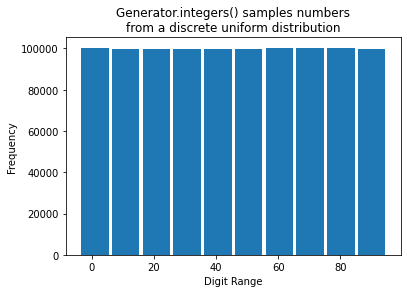

In [9]:
# Initialise random number generator with default bit generator (PCG64)
rng = default_rng(997878)
# Generate 1 million ints of simple random (discrete uniform) data 
ints = rng.integers(1, 100, 1000000, endpoint=True)
# plot number frequencies using matplotlib.pyplot.hist()
plt.hist(ints, bins=10, align="left", rwidth=0.9)

# Get current figure and Axes and set axis labels and plot title
ax = plt.gcf().gca()
ax.set_xlabel('Digit Range')
ax.set_ylabel('Frequency')
plt.title("Generator.integers() samples numbers\nfrom a discrete uniform distribution")
plt.show()

Here, an array of integers is produced, each of which is limited to a different interval.

In [10]:
# Return an array containing 4 integers from 
# intervals [0,2), [0,4), [0,6), and [0,8) respectively 
rng.integers([2, 4, 6, 8])

array([0, 3, 0, 3])

*n-d* arrays can be generated by passing a tuple to size. Also lower and upper bounds can be specified for each position. Size can be inferred from the structure of the interval arguments.

In [59]:
# A 3x3 array of integers in [1, 100]
ints1 = rng.integers(1, 100, size=(3, 3), endpoint=True)

# A 3 element array with intervals [2, 5), [20, 50), and [200, 500)
ints2 = rng.integers([2, 20, 200], [5, 50, 500])

#  A 3x3 array with intervals:
#  [2, 300), [20, 300), [200, 300)
#  [2, 400), [20, 400), [200, 400)
#  [2, 500), [20, 500), [200, 500)
ints3 = rng.integers([2, 20, 200], [[300], [400], [500]])

print(f"5x5:\n{ints1}\n\n3 element:\n{ints2}\n\n3x3:\n{ints3}")

5x5:
[[41 79 83]
 [ 3 13 92]
 [31 96 69]]

3 element:
[  2  33 223]

3x3:
[[ 63 250 240]
 [ 72 366 293]
 [424 167 445]]


Simulating one million rolls of one and two fair dice using `Generator.integers()`. Note that a single dice produces a discrete uniform distribution and a 2 dice produce a discrete triangular distribution.

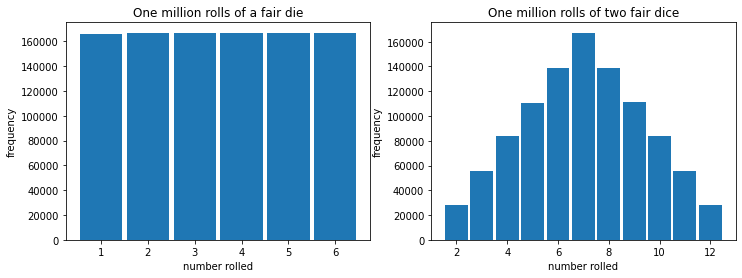

In [101]:
# Simulate 1 million die rolls
die_rolls = rng.integers(1, 6, size=1000000, endpoint=True)
# Simulating 1 million rolls of a pair of dice
two_die_rolls = rng.integers(1, 6, size=(1000000, 2), endpoint=True)

# Plot the distributions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
ax1.hist(die_rolls, bins=(range(1,8)), align="left", rwidth=0.9)
ax1.set_xlabel('number rolled')
ax1.set_ylabel('frequency')
ax1.set_title("One million rolls of a fair die")

ax2.hist(np.sum(two_die_rolls, axis=1), bins=(range(2, 14)), align="left", rwidth=0.9)
ax2.set_xlabel('number rolled')
ax2.set_ylabel('frequency')
ax2.set_title("One million rolls of two fair dice")
plt.show()

### `numpy.random.Generator.random()`
Signature: `random(size=None, dtype=np.float64, out=None)`

This method generates floats, $n$, such that $0.0{\le}n{\lt}1.0$. With no arguments the method returns a single number. If an int is passed to the size parameter it is treated as the length of an array or random floats, and if a tuple is passed each element is treated as the size of a dimension in an *n-d* array.

The random floats generated by this method are drawn from a continuous uniform distribution, meaning that the number of possible values is not countable but that each possible value is equally likely to occur. Collections of floats in intervals other than $[0.0, 1.0)$ may be generated by adding the lower interval limit the product of the interval length and the output of `random()`; e.g. $(b-a)(random())+a$ to generate random floats in the interval $[a,b)$.

In [13]:
print(rng.random())
print((10-5)*rng.random()+5)

0.20988957465632074
9.559006160526236


### `numpy.random.Generator.choice`
Signature: `choice(a, size=None, replace=True, p=None, axis=0, shuffle=True)`

This method returns random samples from array-like collections. Passed an int it will behave like [`integers()`](numpy.random.Generator.integers()) and treat the argument as the upper limit of an open interval with 0 as the lower limit, returning a random integer from that interval. The `size` parameter allows the number of choices returned, as well as their shape to be selected in exactly the same manner as in the [`integers()`](numpy.random.Generator.integers()) method. If passed an n-dimensional array the axis along which to take the sample can be specified. If, for instance, a *2-d* array is passed, along with an `axis` argument of 0 (the default), then the method will return a random selection of `size` rows, and `axis=1` will return a random selection of `size` columns. Whether or not the sample is taken with replacement, that is whether a value can be selected more than once, can be specified with the `replace` parameter.

The randaom values are selected using a uniform distribution, with each value having an equal chance of being selected. However, an array-like collection of probabilities can be passed, one for each possible choice. These probabilities must sum to 1.

7


(array([445.,   0.,   0., 432.,   0.,   0., 704.,   0.,   0., 419.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

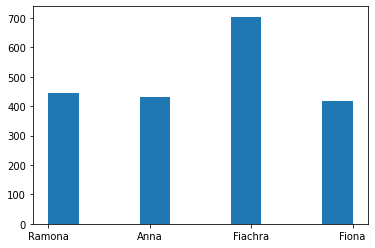

In [14]:
names = ['Anna', 'Ramona', 'Fiachra', 'Fiona']
winner = rng.choice(names, 2, p=[0.2,0.2,0.4,0.2])
xx = rng.choice(4, size=[28,28], p=[0.5, 0.2, 0.2, 0.1])
print(rng.integers(9))
ww = []
for w in range(1000):
    winners = rng.choice(names, 2, p=[0.2,0.2,0.4,0.2], replace=False)
    ww.extend(winners)
plt.hist(ww)

In [15]:
names = [['Anna', 'Ramona', 'Fiachra', 'Fiona'],['Homer','Bart', 'Lisa', 'Maggie']]
print(rng.choice(names, 1, axis=0))

[['Homer' 'Bart' 'Lisa' 'Maggie']]


In [16]:
d = np.arange(100).reshape(10,10)
d

array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
       [20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
       [30, 31, 32, 33, 34, 35, 36, 37, 38, 39],
       [40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
       [50, 51, 52, 53, 54, 55, 56, 57, 58, 59],
       [60, 61, 62, 63, 64, 65, 66, 67, 68, 69],
       [70, 71, 72, 73, 74, 75, 76, 77, 78, 79],
       [80, 81, 82, 83, 84, 85, 86, 87, 88, 89],
       [90, 91, 92, 93, 94, 95, 96, 97, 98, 99]])

In [17]:
print(rng.choice(d, 5, axis=0))

[[20 21 22 23 24 25 26 27 28 29]
 [20 21 22 23 24 25 26 27 28 29]
 [50 51 52 53 54 55 56 57 58 59]
 [50 51 52 53 54 55 56 57 58 59]
 [90 91 92 93 94 95 96 97 98 99]]


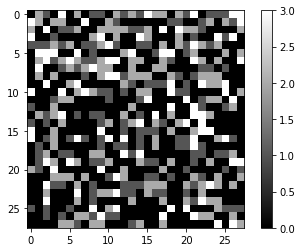

In [18]:
plt.imshow(xx, cmap="gray")
plt.colorbar()

### `numpy.random.Generator.bytes`
Signature: `bytes(length)`

The `bytes` method returns a string of random bytes of the length passed.

In [19]:
x = rng.bytes(50).decode('cp1250')
type(x)


str

\xe2h\x18\x08\x04\xab\xeco

## Random permutations of sequences with `numpy.random`

Three methods are provided for the random reordering of sequences: `shuffle`, `permutation`, and `permuted`.

### `numpy.random.Generator.shuffle`
Signature: shuffle(x, axis=0)

The `shuffle()` method shuffles an array-like in-place. If passed an *n-d* array, the `axis` parameter, which defaults to 0, determines which axis gets shuffled. For instance, in the case of a *2-d* array, `axis=0` causes the order of the rows to change without reordering the values within the rows, while `axis=1` reorders the columns without affecting element order within the columns.

### `numpy.random.Generator.permutation`
Signature: `permutation(x, axis=0)

If passed an int, $n$, the `permutation()` method generates an evenly spaced range of interval $[0, n)$ using `numpy.arange()`, shuffles then returns it as a *1-d* numpy array. Passed an *array-like*, the method shuffles a copy along the specified axis and returns the copy.

In [20]:
x = np.arange(9).reshape(3,3)
display(x)
y = rng.permutation(x.flatten()).reshape(3,3)
display(y)

array([[0, 1, 2],
       [3, 4, 5],
       [6, 7, 8]])

array([[6, 3, 4],
       [8, 2, 7],
       [1, 0, 5]])

### `numpy.random.Generator.permuted`
Signature:`permuted(x, axis=None, out=None)`

This method shuffles the passed *array-like* along the specified axis.

## Some distribution functions

### 1. The normal distribution
`random.Generator.normal()`
$$ f(x)=\frac{1}{\sigma\sqrt{2\pi}}e^{-\frac{1}{2}(\frac{x-\mu}{\sigma})^2} $$

1. Description of normal distribution.
    1. Central limit theorem
1. Description of Generator.normal()
1. Demonstration of Generator.normal()

### 2. The binomial distribution

In [21]:
b = rng.geometric(0.5, 1000000)
for z in range(1, 11):
    print((b == z).sum() / 1000000)


0.500273
0.250001
0.12556
0.061625
0.031325
0.015719
0.007791
0.00382
0.001956
0.000986


In [22]:
bin = rng.binomial(1, 0.5, 1000000)
# for z in range(1, 11):
#     print((bin == z).sum() / 1000000)
np.unique(bin)

array([0, 1])

In [23]:
results = []
for toss in range(100000):
    results.append(rng.integers(2)) 

In [24]:
results

[1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,


### 3. The standard student's t distribution 

### 4. The Zipf Distribution

### 5. The Gumbel Distribution
#### `random.Generator.gumbel`
$$ p(x)=\frac{e^{-(x-\mu)/\beta}}{\beta}e^{-e^{-(x-\mu)/\beta}} $$

## Seeds

PCG64 Details
Comparison between PCG64 and Mersenne Twister with focus on on performance (i.e. how does PCG64 outperform MT19937?)

Setting seeds in numpy rng

***
## References

## RNG General
[1] https://www.pcg-random.org/rng-basics.html

### PCG
[2] Lemire, D., 2017, On Melissa O’Neill’s PCG random number generator, https://lemire.me/blog/2017/08/15/on-melissa-oneills-pcg-random-number-generator/

[3] O' Neill, M., 2014, PCG, A Family of Better Random Number Generators, https://www.pcg-random.org/

[4] O' Neill, M., 2014, PCG: A Family of Simple Fast Space-Efficient Statistically Good Algorithms for Random Number Generation, https://www.pcg-random.org/pdf/hmc-cs-2014-0905.

### RNG Seeding
[5] Woodcock, H., 2021, Stop using numpy.random.seed(), https://towardsdatascience.com/stop-using-numpy-random-seed-581a9972805f

### Numpy Docs
[7] https://numpy.org/doc/stable/reference/random/index.html

[8] https://numpy.org/doc/stable/reference/random/bit_generators/index.html

[9] https://numpy.org/doc/stable/reference/random/bit_generators/generated/numpy.random.BitGenerator.html

[10] Generating random samples from user-defined
distributions
The Stata Journal (2011)
11, Number 2, pp. 299–304
Katar ́ına Luk ́acsy

[11] Bonilla, L.L., Alvaro, M. & Carretero, M. Chaos-based true random number generators. J.Math.Industry 7, 1 (2016). https://doi.org/10.1186/s13362-016-0026-4

[12] Harvard: Haahr, M. (2021). RANDOM.ORG: True Random Number Service. [ONLINE] Available at: https://www.random.org [Accessed 9 November 2021].

[13] Meiser, L.C., Koch, J., Antkowiak, P.L. et al. DNA synthesis for true random number generation. Nat Commun 11, 5869 (2020). https://doi.org/10.1038/s41467-020-19757-y

[14] Neustadter, D. (2019). True Random Number Generators for Heightened Security in Any SoC. [ONLINE] Available at https://www.synopsys.com/designware-ip/technical-bulletin/true-random-number-generator-security-2019q3.html [Accessed 9 November 2021].

[15] Barker, E., Kelsey, J. (2012). Recommendation for Key Management. NIST Special Publication 800-57. NIST. [Accessed 9 November 2021]. Page 4.